In [16]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

In [17]:
data_path = "train.csv"
data = pd.read_csv(data_path)
data

Unnamed: 0  Hour  Minutes  Sensor_alpha  Sensor_beta  Sensor_gamma  \
0              0    22       26    119.910995   242.838324   -316.819222   
1              1    10       16    -90.790536  -269.470767   -182.581844   
2              2    21       42    -20.028003  -147.070212     50.280872   
3              3    21       17    -21.258567     0.467070    -86.164153   
4              4    18       16    -58.154501   -13.051195   -156.501167   
...          ...   ...      ...           ...          ...           ...   
6996        6996    21        0      6.576106   301.050638    146.682819   
6997        6997    18       57     -6.169382  -317.652257   -161.644320   
6998        6998    22       47     -7.289684  -406.732525   -212.097250   
6999        6999    18       14    -92.317105  -191.555040     88.371271   
7000        7000    21       31    -72.083585   -11.434977    -52.961743   

      Sensor_alpha_plus  Sensor_beta_plus  Sensor_gamma_plus  Insect  
0            250.195048        -53.547777        -112.049983       2  
1             95.394941         37.291944          48.525180       0  
2            -90.750386        -50.476556          85.399009       1  
3            -21.813529       -209.256006          16.291882       0  
4             48.392938       -110.008860         -10.285138       2  
...                 ...               ...                ...     ...  
6996        -209.480741       -129.776336         -51.226256       1  
6997         248.055724       -112.626344          99.463913       0  
6998         248.745127        116.893077          32.806150       0  
6999          38.728565        -39.050466          20.356711       0  
7000         -72.696385        145.299227        -143.856243       1  

[7001 rows x 10 columns]

Column "Unnamed: 0" contains the index of each sample, so we'll get rid of it.

We'll also combine the Hour and Minutes columns into a single Time column.

In [18]:
data = data.drop(columns="Unnamed: 0")
data["Time"] = data["Hour"] + data["Minutes"]/60
data = data.drop(columns=["Hour", "Minutes"])
data.describe()

Sensor_alpha  Sensor_beta  Sensor_gamma  Sensor_alpha_plus  \
count   7001.000000  7001.000000   7001.000000        7001.000000   
mean       0.477171   -29.974117     -5.624690           7.188060   
std       99.294856   133.095125    115.871391         122.327980   
min     -404.898823  -656.272666   -448.478039        -437.205393   
25%      -68.573905  -116.060383    -83.508747         -79.496687   
50%       -0.287447   -36.171567     -1.217606          -1.133567   
75%       66.480795    56.637778     76.870277          93.285286   
max      351.256221   518.395878    378.349287         462.556319   

       Sensor_beta_plus  Sensor_gamma_plus       Insect         Time  
count       7001.000000        7001.000000  7001.000000  7001.000000  
mean          -0.757901          -0.554533     0.595772    20.089013  
std          100.039477         100.535951     0.661604     3.515934  
min         -387.567443        -374.961689     0.000000     1.016667  
25%          -68.061596         -69.652647     0.000000    19.616667  
50%           -0.444124           0.027128     0.000000    21.200000  
75%           66.181909          67.838524     1.000000    21.750000  
max          345.279240         363.682391     2.000000    23.983333

Plot all pairs of features 

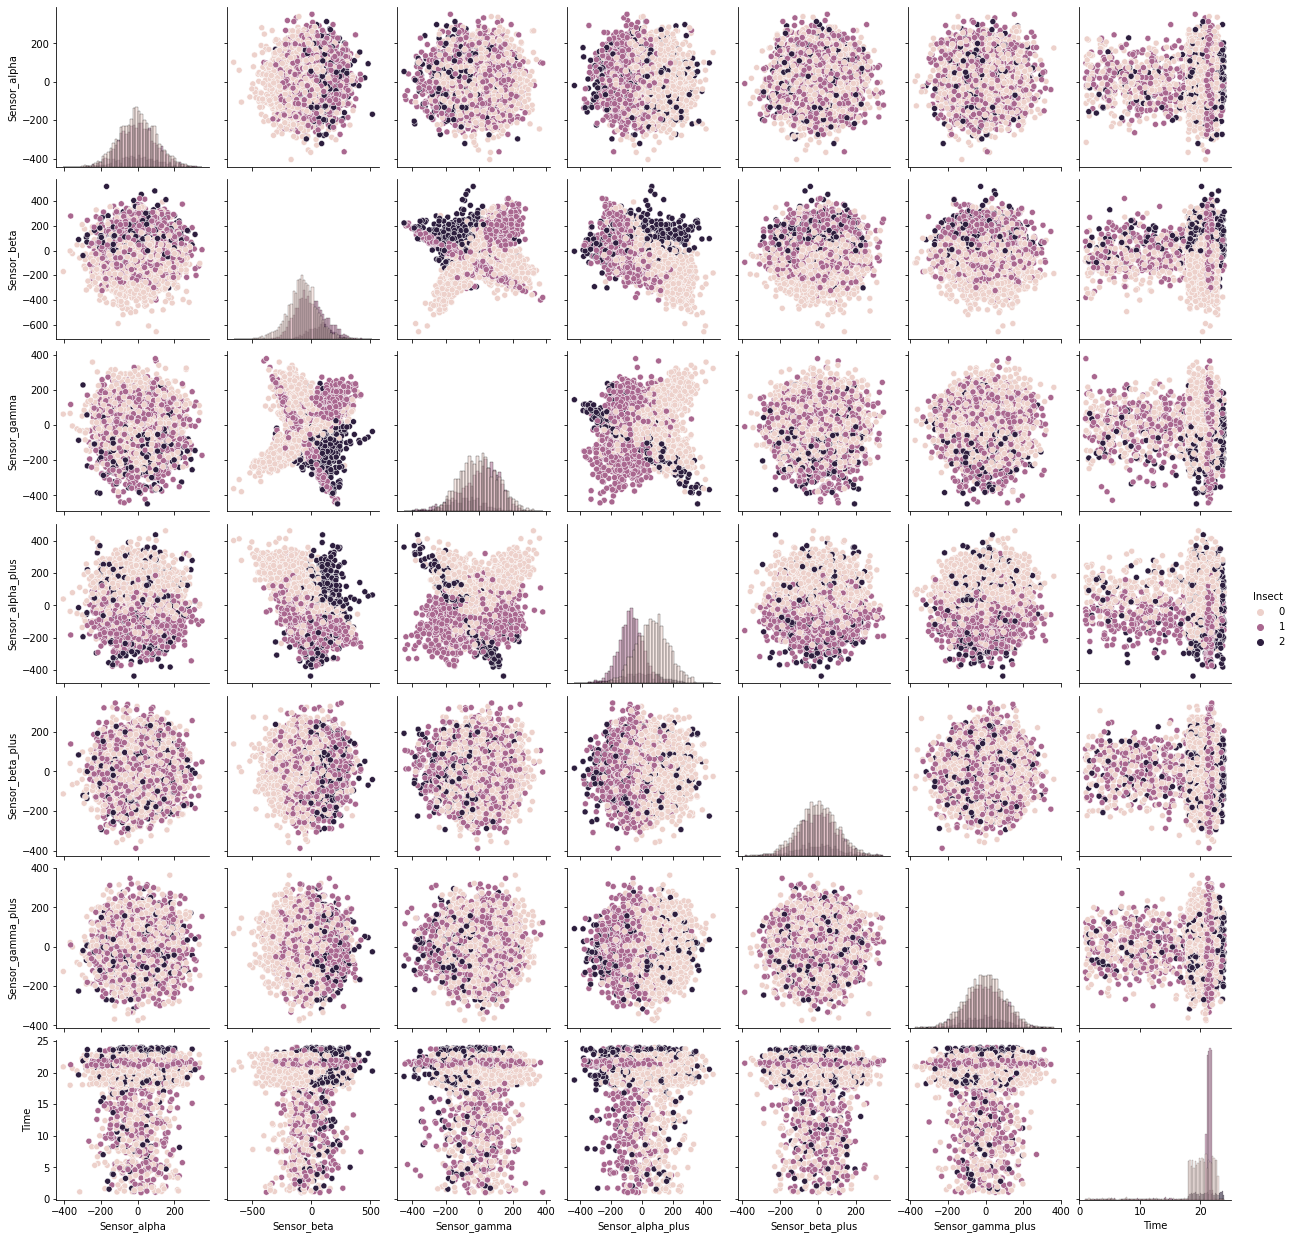

In [13]:
sns.pairplot(data, hue="Insect", diag_kind="hist")

"Sensor_beta", "Sensor_gamma" and "Sensor_alpha_plus" seem to be the most significant features. Time is also significant, but at first sight there doesn't seem to be any significant correlation between it and the sensor values.

Let's make separate plots for each insect to see the distributions better.

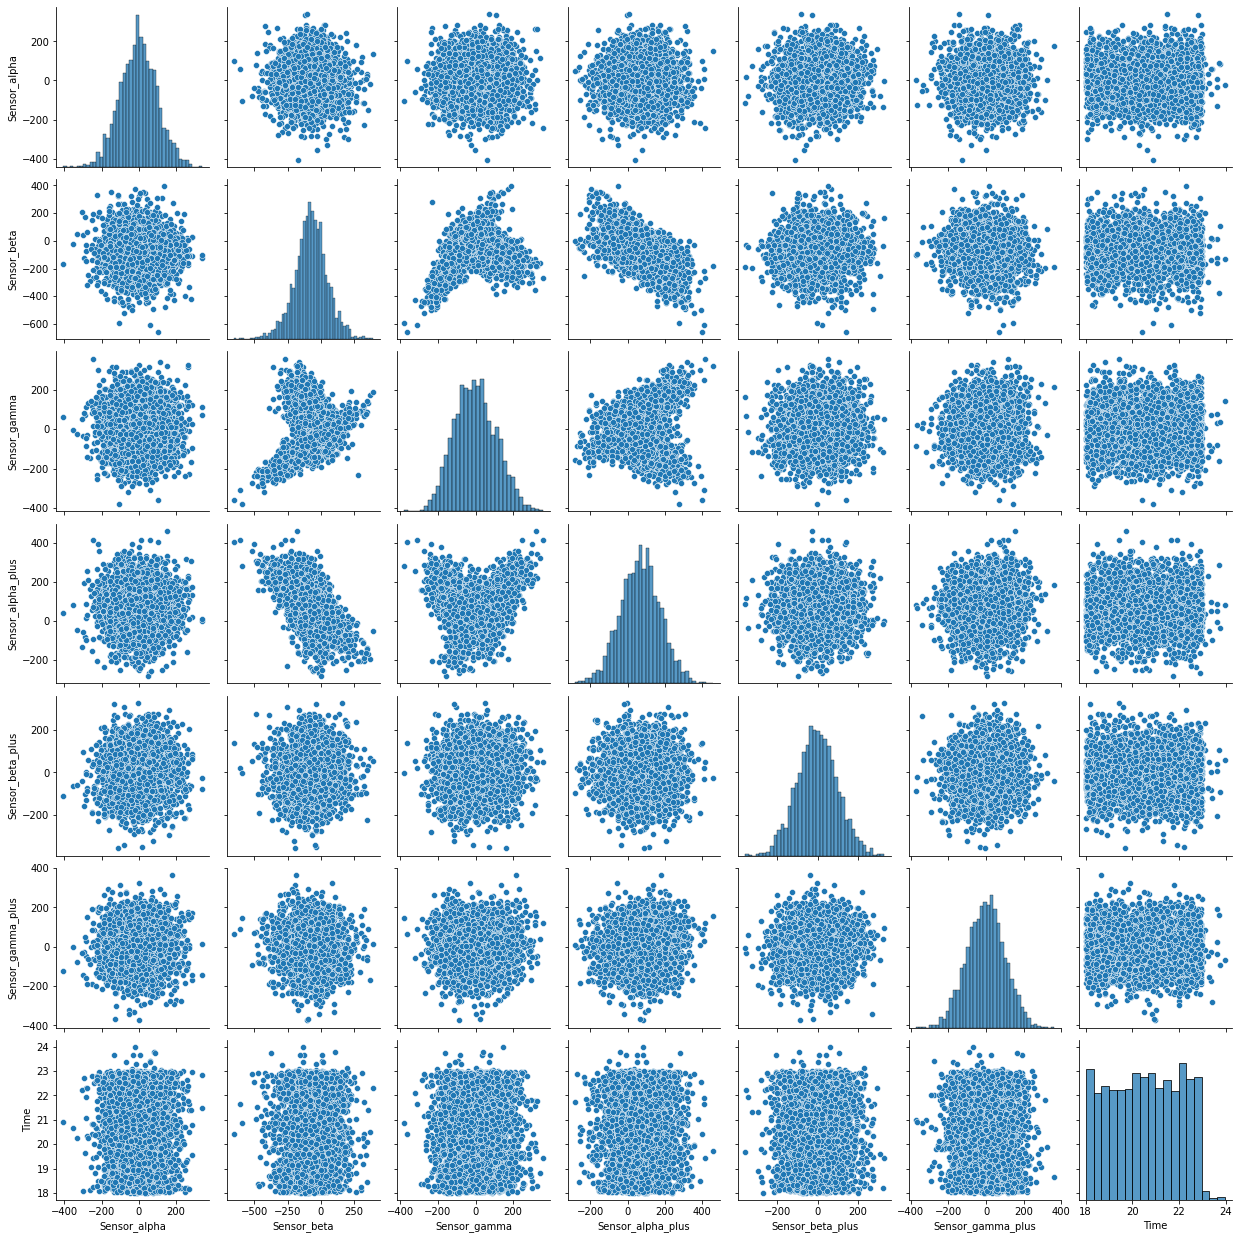

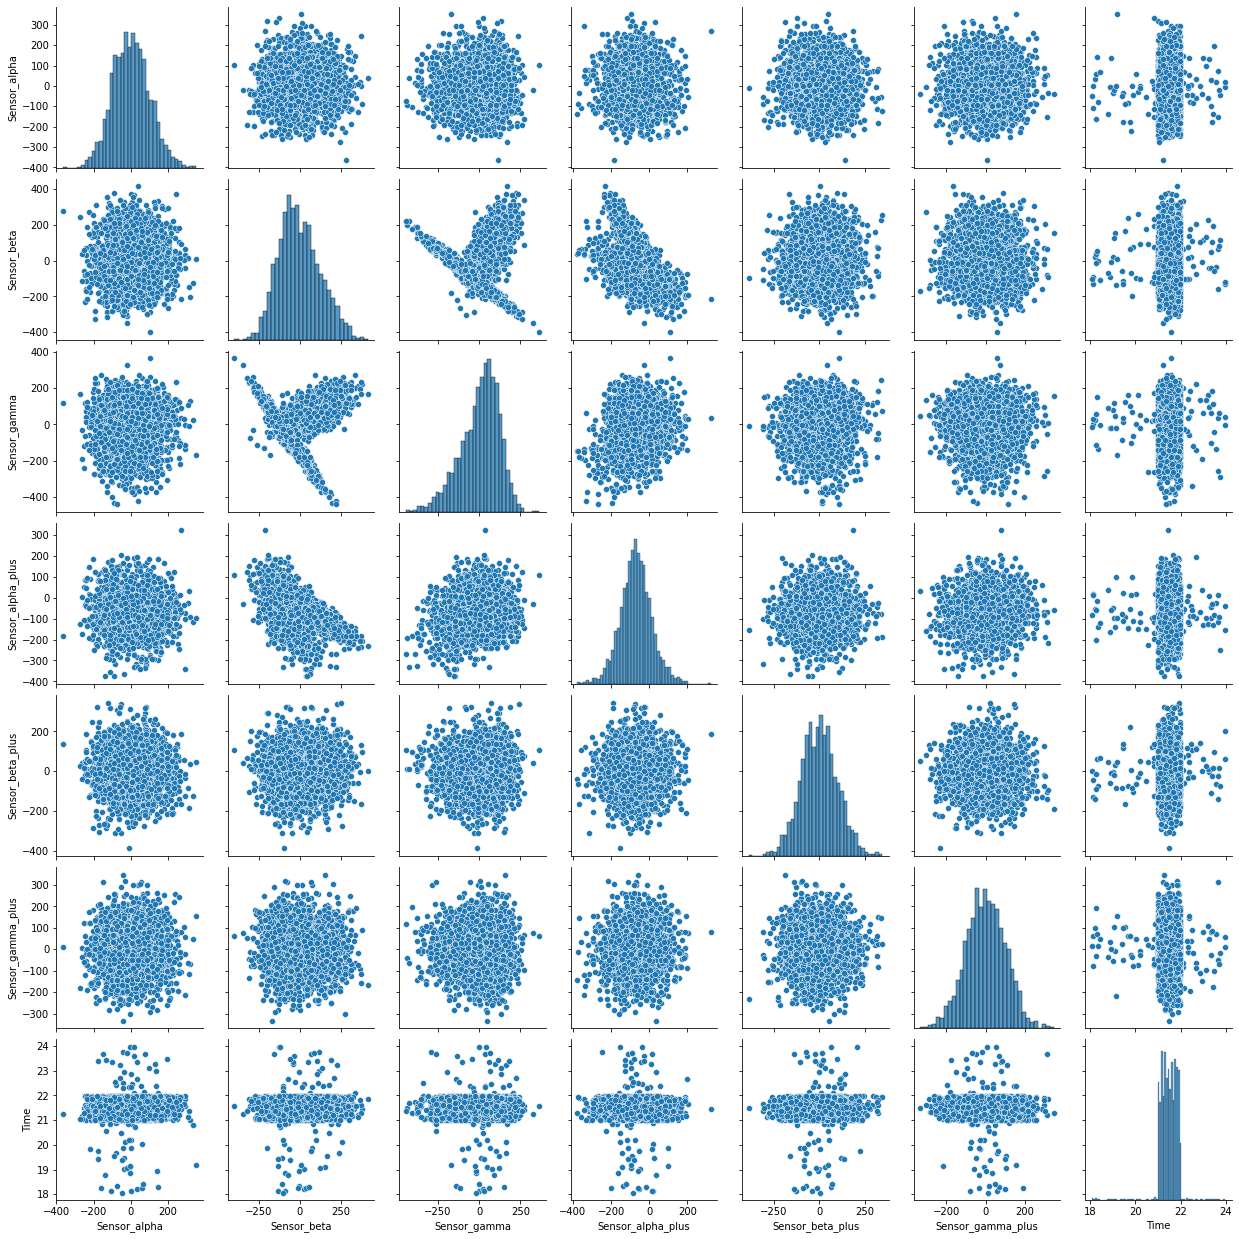

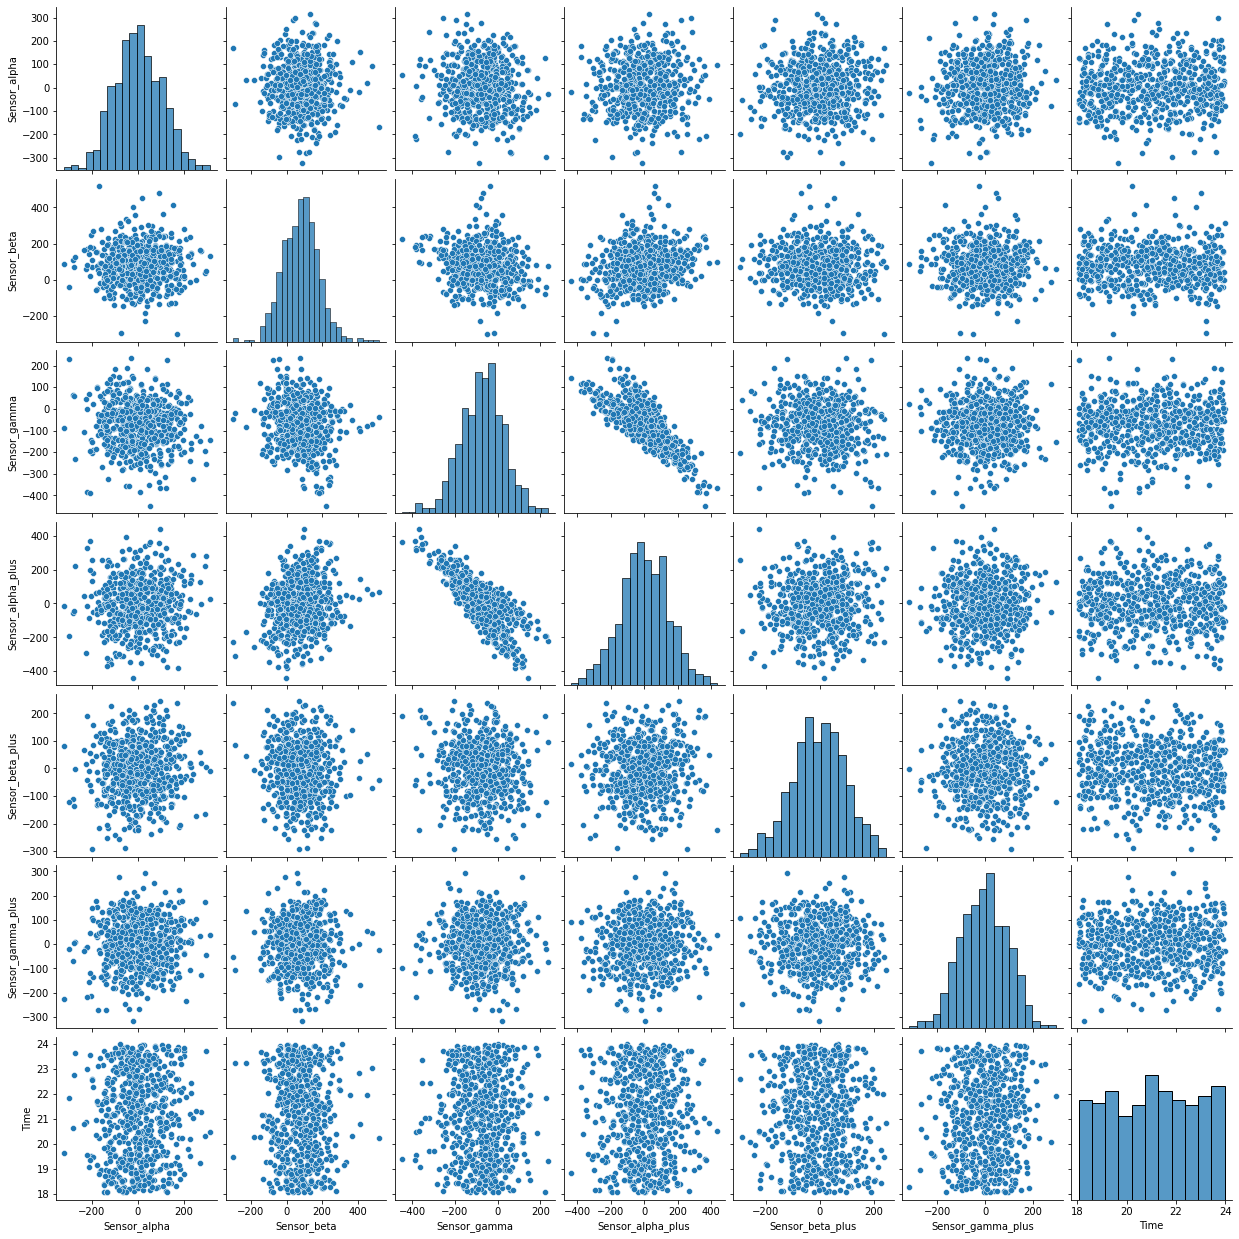

In [20]:
for _, insect_data in data.groupby("Insect"):
    sns.pairplot(insect_data[insect_data["Time"] > 18].drop(columns="Insect"), diag_kind="hist")

"Sensor_beta", "Sensor_gamma" and "Sensor_alpha_plus" seem to follow a mixture distribution with two components.
Let's evaluate the hypothesis that other features might be dependent on the component of the mixture. For this we'll fit a gaussian mixture distribution.

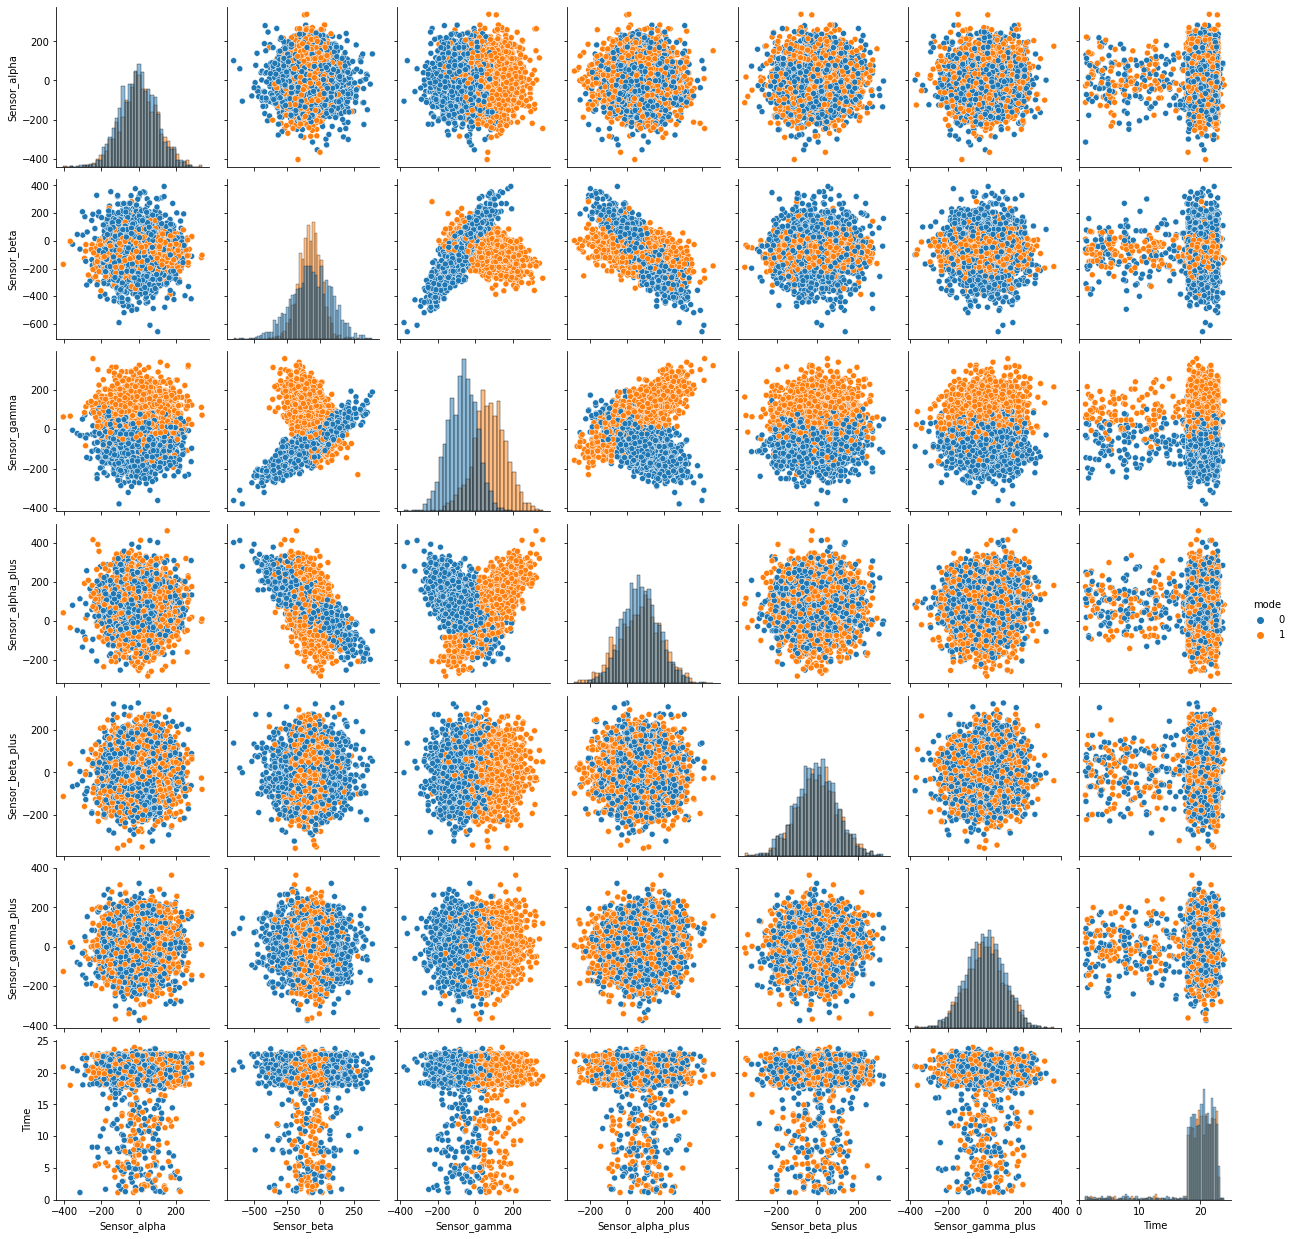

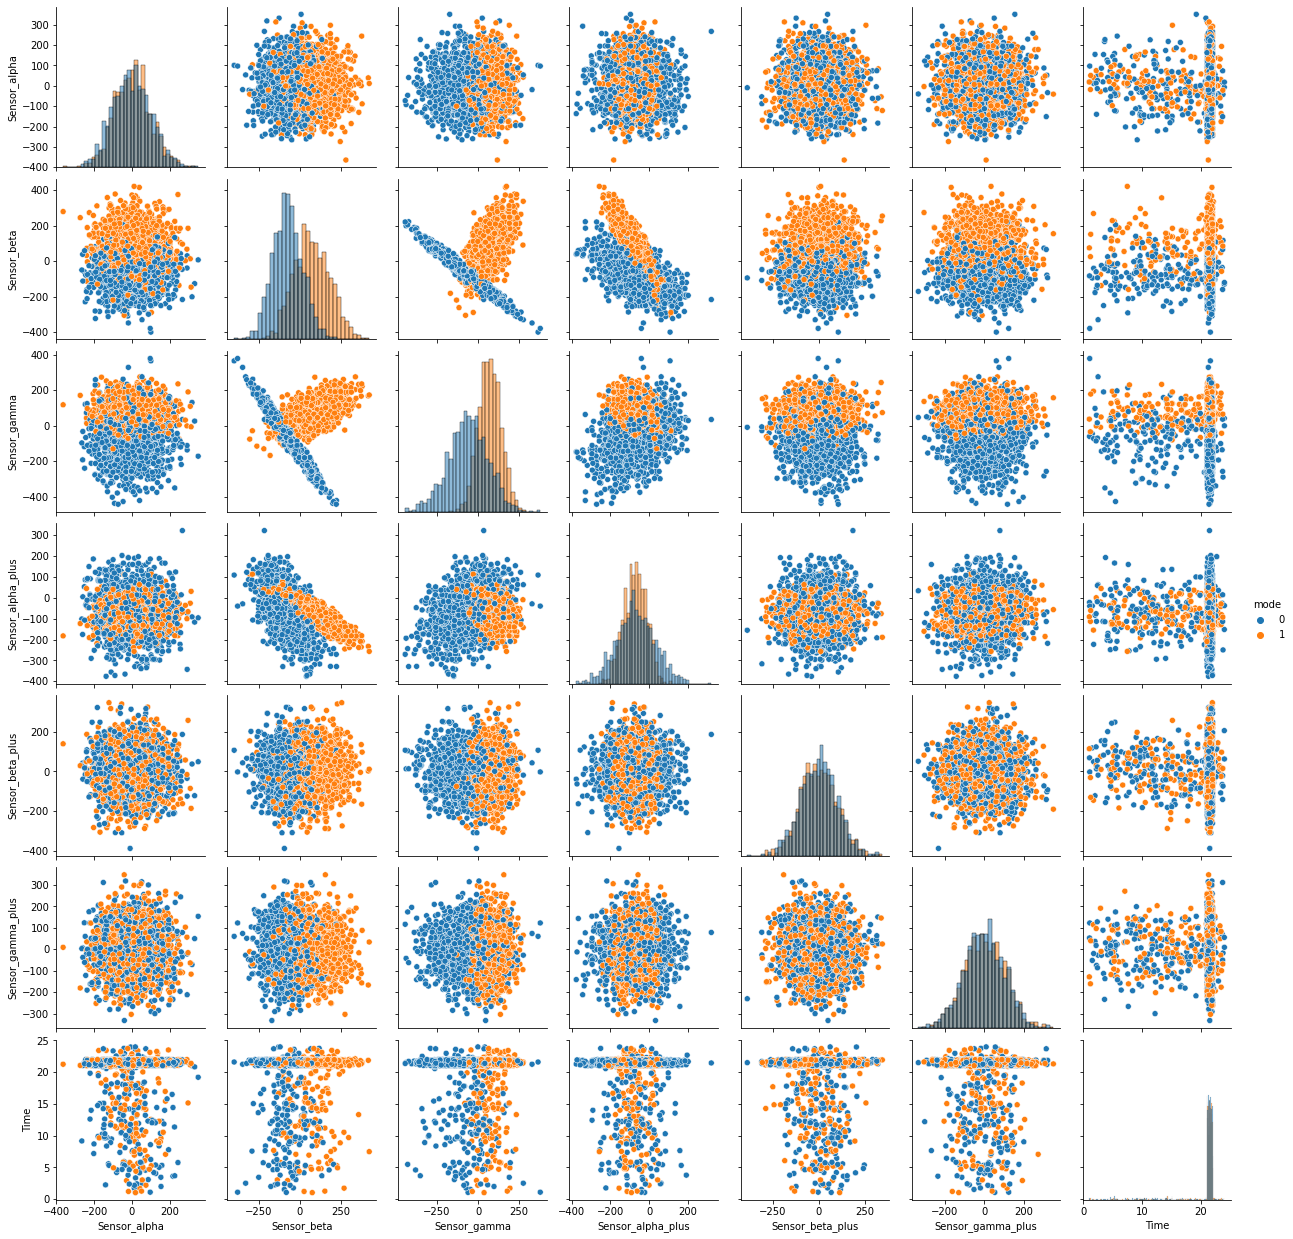

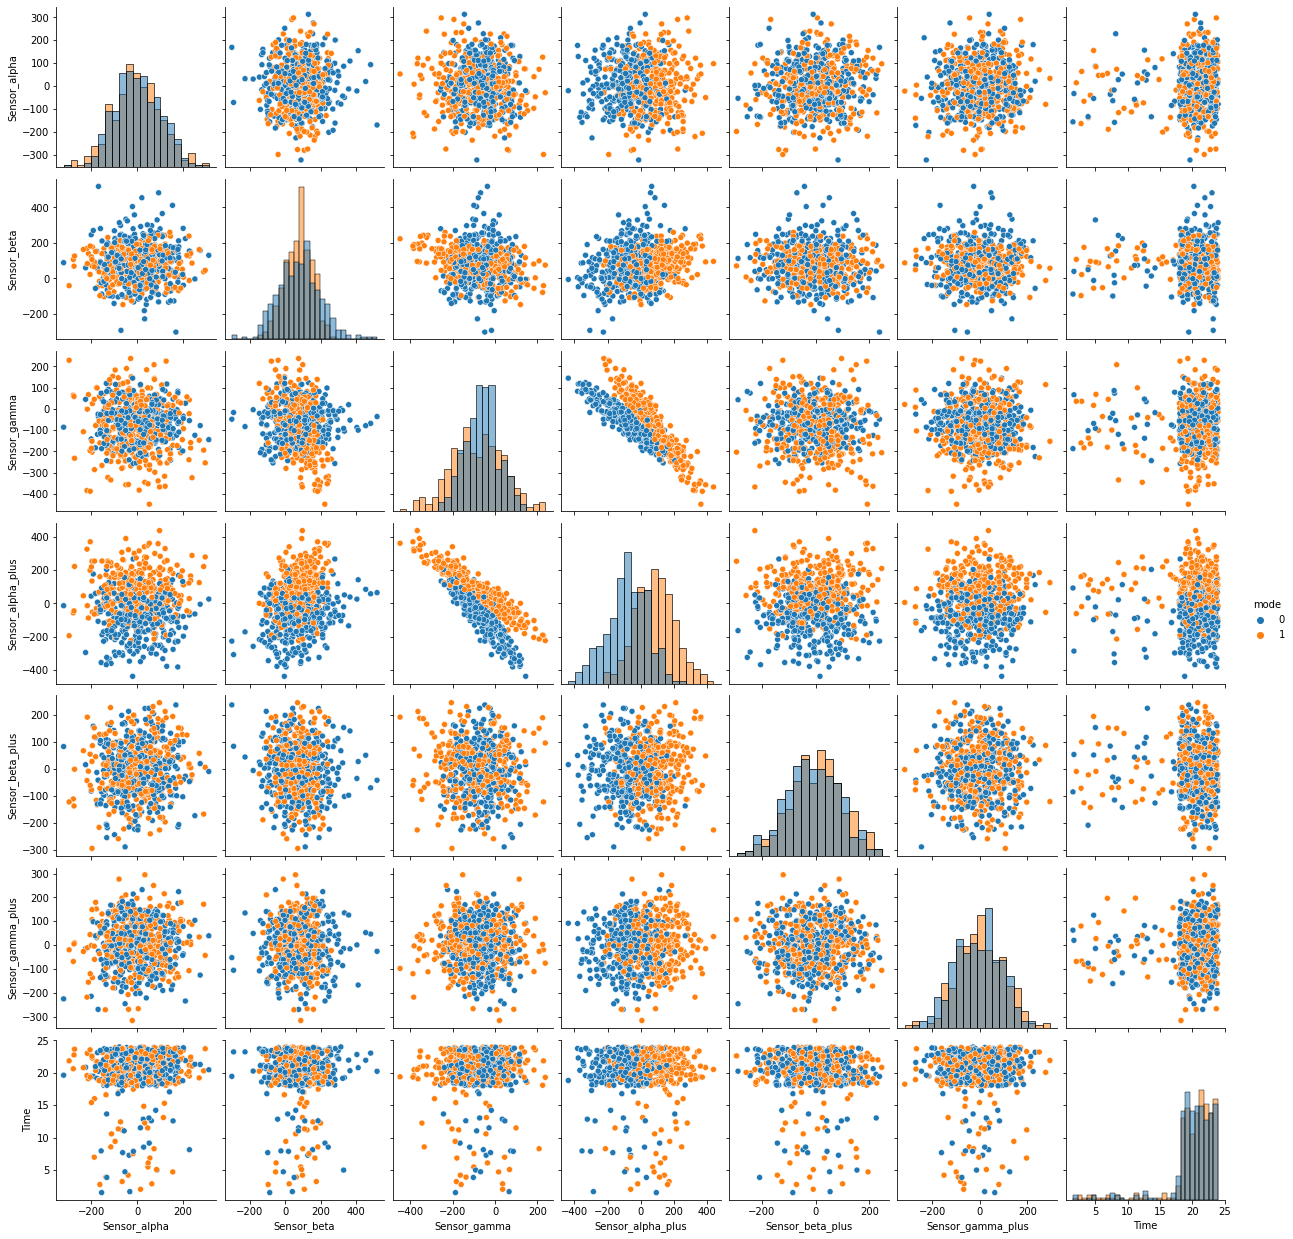

In [22]:
from sklearn.mixture import GaussianMixture

for insect in (0, 1, 2):
    features = ["Sensor_beta", "Sensor_gamma", "Sensor_alpha_plus"]
    data_single_insect = data[data["Insect"] == insect].drop(columns="Insect")

    model = GaussianMixture(
        n_components=2,it
        n_init=20
    )
    mode = model.fit_predict(data_single_insect[features])

    data_single_insect["mode"] = mode
    sns.pairplot(data_single_insect, hue="mode", diag_kind="hist")

There doesn't seem to be any dependence of the other features with the component of the mixture. Let's go back and take a closer look at the "Time" feature

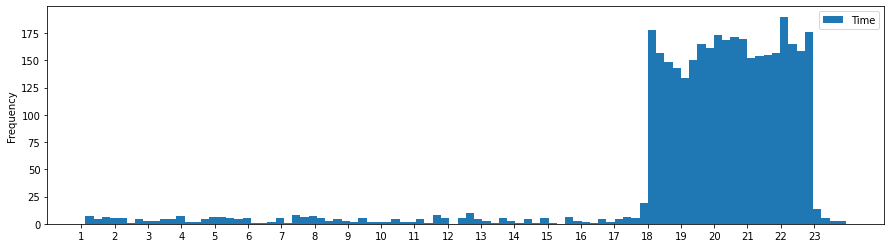

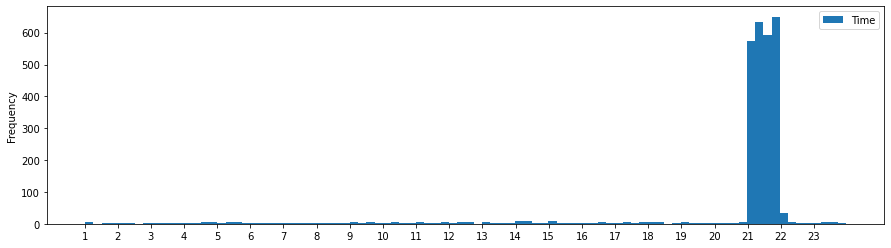

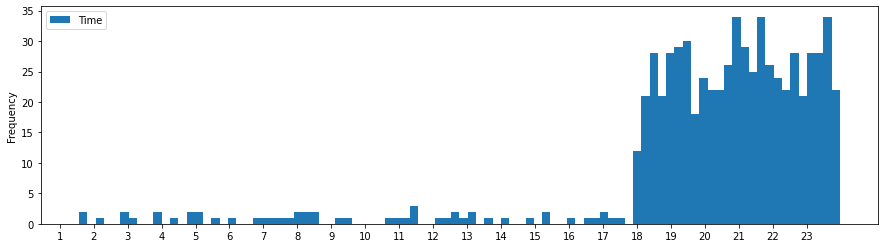

In [46]:
data.groupby("Insect").plot(y="Time", kind="hist", bins=92, figsize=(15, 4), xticks=range(1, 24));

"Time" seems to follow a piecewice constant distribution with two parts. Also, the bounds of the intervals lay at the stroke of an hour, so we might just use the "Hour" feature and drop the minutes when modeling.